In [2]:
import pandas as pd

filepath = r"C:\Ai_project\AI_2026\Day07 SVM\groupA\knbs\train.csv"

df = pd.read_csv(filepath)

# ────────────────────────────────────────────────
# Step 1: See what columns you ACTUALLY have
# ────────────────────────────────────────────────
print("All columns in the file:")
print(df.columns.tolist())           # exact names
print("\nShape:", df.shape)
print("\nFirst 3 rows:\n")
print(df.head(3))

All columns in the file:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Shape: (891, 12)

First 3 rows:

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


In [4]:
# Classification: predict survival
X = df.drop('Survived', axis=1)
y = df['Survived']

# Optional: drop useless / hard-to-use columns right away
X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

In [5]:
cols_to_drop = ['thalach', 'target']
cols_that_exist = [col for col in cols_to_drop if col in df.columns]

if cols_that_exist:
    X = df.drop(cols_that_exist, axis=1)
else:
    print("None of the columns to drop were found → using all features")
    X = df.copy()

# Then decide what y should be
# Example guesses — change according to your real goal
if 'Survived' in df.columns:
    y = df['Survived']
elif 'target' in df.columns:
    y = df['target']
elif 'num' in df.columns:
    y = df['num']
else:
    print("Don't know what the target is — please tell me which column to predict")
    # or raise an error / ask user

None of the columns to drop were found → using all features


In [7]:
import pandas as pd

# Your file path (use raw string to avoid \\ problems)
filepath = r"C:\Ai_project\AI_2026\Day07 SVM\groupA\knbs\train.csv"

df = pd.read_csv(filepath)

# 1. Quick look at the data
print("Columns in your file:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df[['Survived', 'Sex']].head())

# 2. Survival rate by Sex (the classic Titanic insight)
print("\nSurvival counts by Sex:")
print(df.groupby('Sex')['Survived'].value_counts())

print("\nSurvival percentage by Sex:")
print(df.groupby('Sex')['Survived'].mean().round(3) * 100, "%")

# Cleaner version with percentages
survival_by_sex = pd.crosstab(df['Sex'], df['Survived'], normalize='index') * 100
survival_by_sex.columns = ['Died (%)', 'Survived (%)']
print("\nSurvival rate by gender:")
print(survival_by_sex.round(1))

Columns in your file:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First 5 rows:
   Survived     Sex
0         0    male
1         1  female
2         1  female
3         1  female
4         0    male

Survival counts by Sex:
Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: count, dtype: int64

Survival percentage by Sex:
Sex
female    74.2
male      18.9
Name: Survived, dtype: float64 %

Survival rate by gender:
        Died (%)  Survived (%)
Sex                           
female      25.8          74.2
male        81.1          18.9


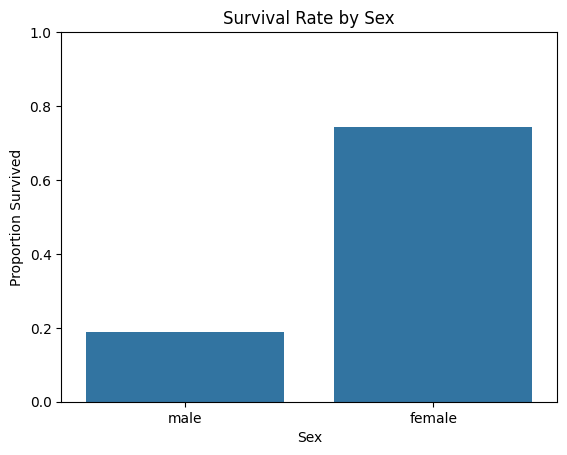

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Sex', y='Survived', data=df, errorbar=None)
plt.title('Survival Rate by Sex')
plt.ylabel('Proportion Survived')
plt.ylim(0, 1)
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ────────────────────────────────────────────────
# 1. Load and prepare data
# ────────────────────────────────────────────────
filepath = r"C:\Ai_project\AI_2026\Day07 SVM\groupA\knbs\train.csv"
df = pd.read_csv(filepath)

# Basic cleaning (you can expand this)
df = df.dropna(subset=['Age', 'Fare', 'Embarked'])  # drop rows with missing target or key features
df['Age'] = df['Age'].fillna(df['Age'].median())    # or keep as-is if you prefer imputation pipeline

# Features we'll use
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Note: We include Fare in features here only for demonstration — normally you'd drop it if predicting Fare

# If predicting Fare → drop it from X
X = df.drop(['Fare', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1, errors='ignore')
y = df['Fare']

print("X shape:", X.shape, " | y shape:", y.shape)

# ────────────────────────────────────────────────
# 2. Train-test split
# ────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ────────────────────────────────────────────────
# 3. Preprocessing pipeline
# ────────────────────────────────────────────────
numeric_features = ['Age', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# ────────────────────────────────────────────────
# 4. Non-linear SVR model (RBF kernel is the most common non-linear choice)
# ────────────────────────────────────────────────
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(
        kernel='rbf',          # non-linear kernel (most popular)
        C=1.0,                 # regularization (smaller = more regularization)
        epsilon=0.1,           # margin of tolerance
        gamma='scale'          # 'scale' / 'auto' / number → kernel coefficient
    ))
])

# ────────────────────────────────────────────────
# 5. Train
# ────────────────────────────────────────────────
svr_pipeline.fit(X_train, y_train)

# ────────────────────────────────────────────────
# 6. Predict & Evaluate
# ────────────────────────────────────────────────
y_pred = svr_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nNon-linear SVR Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

# Optional: show a few predictions
print("\nSample predictions vs actual:")
comparison = pd.DataFrame({'Actual': y_test[:8], 'Predicted': y_pred[:8]})
print(comparison.round(1))

X shape: (712, 6)  | y shape: (712,)

Non-linear SVR Performance:
MAE:  25.49
RMSE: 67.18
R²:   -0.007

Sample predictions vs actual:
     Actual  Predicted
641    69.3       25.1
496    78.3       36.6
262    79.6       35.6
311   262.4       31.1
551    26.0       13.0
550   110.9       27.5
279    20.2       21.8
268   153.5       30.0


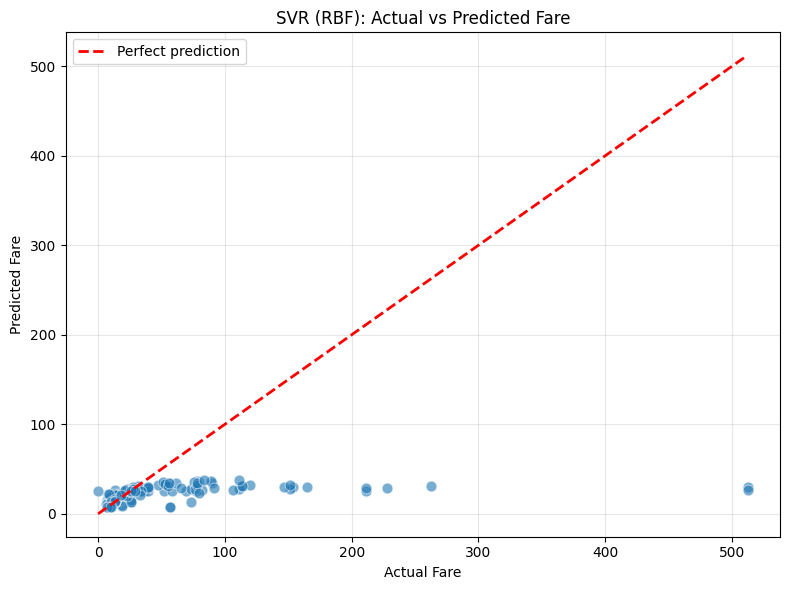

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# After predictions: y_test, y_pred already exist

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='w', s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('SVR (RBF): Actual vs Predicted Fare')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

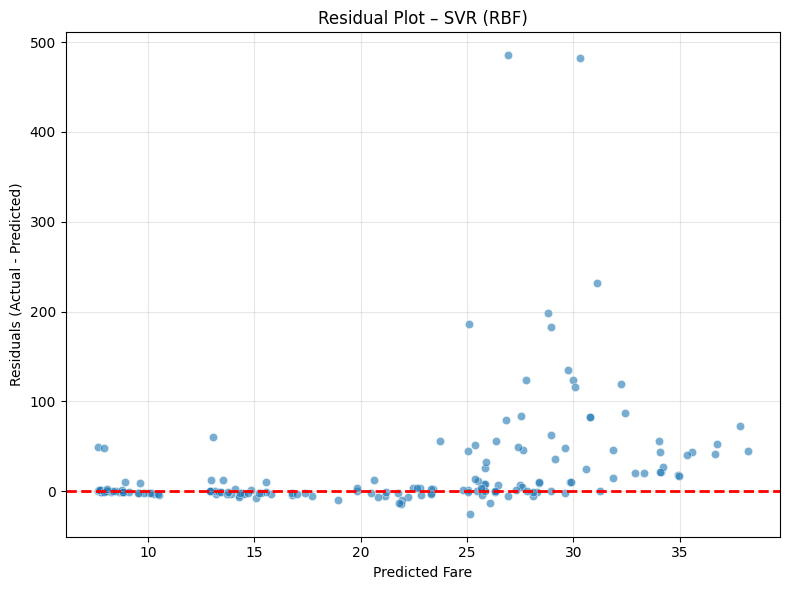

In [11]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Fare')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot – SVR (RBF)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\kiki\AppData\Local\Temp\ipykernel_30604\4024884584.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


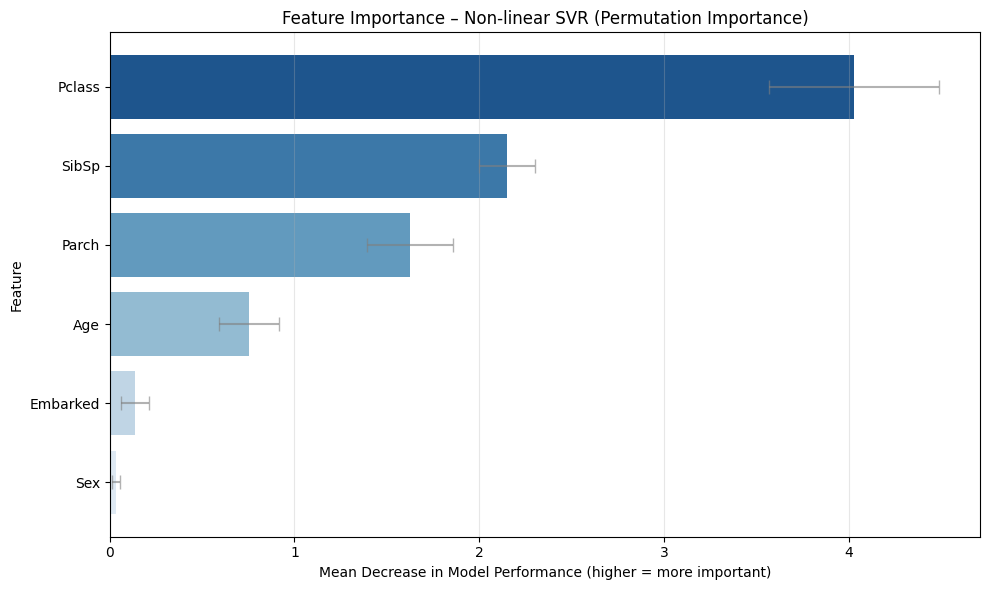

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# ────────────────────────────────────────────────
# Calculate permutation importance
# (run this after svr_pipeline.fit(X_train, y_train))
# ────────────────────────────────────────────────
perm_importance = permutation_importance(
    svr_pipeline, 
    X_test, y_test,
    n_repeats=10,          # more repeats = more stable but slower
    random_state=42,
    scoring='neg_mean_absolute_error'   # or 'r2', 'neg_mean_squared_error'
)

# Create DataFrame for plotting
feat_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

# Sort by importance (descending)
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# ────────────────────────────────────────────────
# Visualization (very similar style to your linear example)
# ────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_importance,
    palette='Blues_r'
)

# Optional: add error bars
plt.errorbar(
    x=feat_importance['Importance'],
    y=feat_importance['Feature'],
    xerr=feat_importance['Std'],
    fmt='none', ecolor='gray', capsize=5, alpha=0.6
)

plt.title('Feature Importance – Non-linear SVR (Permutation Importance)')
plt.xlabel('Mean Decrease in Model Performance (higher = more important)')
plt.ylabel('Feature')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

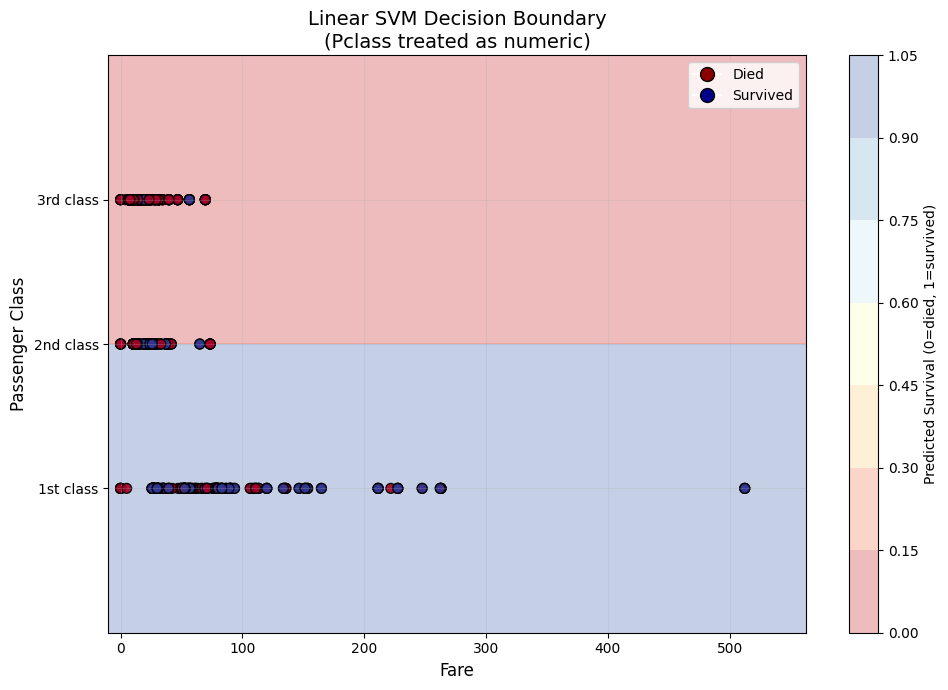

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# Load
df = pd.read_csv(r'C:\Ai_project\AI_2026\Day07 SVM\groupA\knbs\train.csv')
df = df[['Pclass', 'Fare', 'Survived']].dropna(subset=['Fare', 'Pclass'])

X = df[['Pclass', 'Fare']]
y = df['Survived']

# Model – treat Pclass as numeric
scaler = StandardScaler()
model = make_pipeline(scaler, SVC(kernel='linear', C=1.0, random_state=42))
model.fit(X, y)

# Grid
fare_min, fare_max = X['Fare'].min() - 10, X['Fare'].max() + 50
xx_fare, yy_pclass = np.meshgrid(
    np.linspace(fare_min, fare_max, 400),
    np.linspace(0, 4, 300)          # a bit wider than 1–3
)

grid_points = pd.DataFrame({
    'Pclass': yy_pclass.ravel(),
    'Fare'  : xx_fare.ravel()
})

Z = model.predict(grid_points).reshape(xx_fare.shape)

# Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx_fare, yy_pclass, Z, alpha=0.3, cmap='RdYlBu')
plt.colorbar(label='Predicted Survival (0=died, 1=survived)')

plt.scatter(X['Fare'], X['Pclass'], c=y, cmap='RdYlBu', edgecolor='k', s=50, alpha=0.9)

plt.yticks([1,2,3], ['1st class', '2nd class', '3rd class'])
plt.xlabel('Fare', fontsize=12)
plt.ylabel('Passenger Class', fontsize=12)
plt.title('Linear SVM Decision Boundary\n(Pclass treated as numeric)', fontsize=14)
plt.grid(True, alpha=0.25)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Died',    markerfacecolor='darkred',  markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Survived',markerfacecolor='darkblue', markersize=10, markeredgecolor='k'),
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

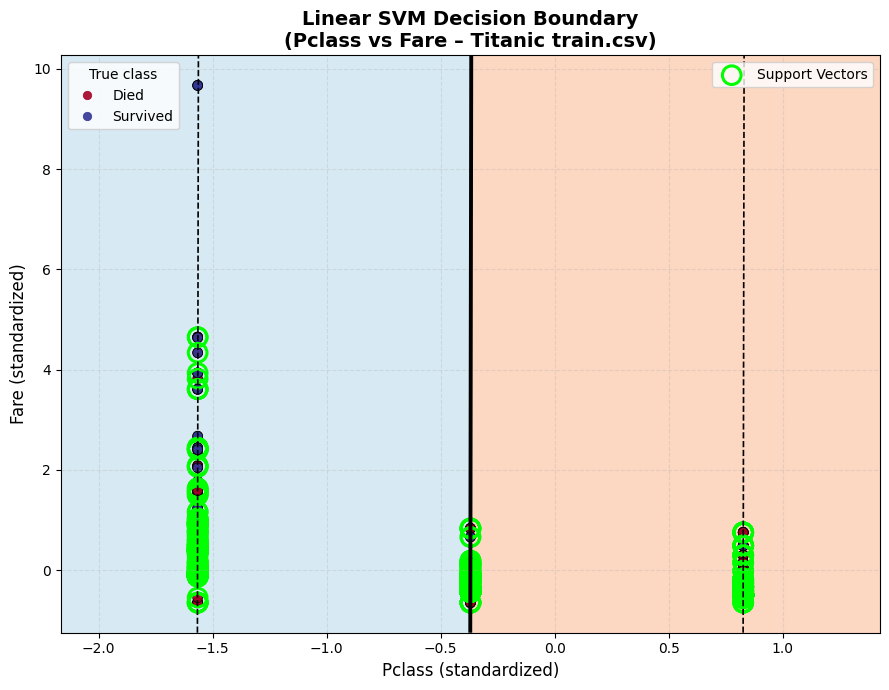

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ────────────────────────────────────────────────
# 1. Load training data (has Survived)
# ────────────────────────────────────────────────
filepath = r'C:\Ai_project\AI_2026\Day07 SVM\groupA\knbs\train.csv'
df = pd.read_csv(filepath)

# ────────────────────────────────────────────────
# 2. Keep only the features we want to visualize + target
# ────────────────────────────────────────────────
df = df[['Pclass', 'Fare', 'Survived']]

# Simple missing value handling
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# ────────────────────────────────────────────────
# 3. Features & target
# ────────────────────────────────────────────────
X_vis = df[['Pclass', 'Fare']].values
y_vis = df['Survived'].values

# ────────────────────────────────────────────────
# 4. Scale features (SVM needs this!)
# ────────────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vis)

# ────────────────────────────────────────────────
# 5. Train Linear SVM
# ────────────────────────────────────────────────
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_scaled, y_vis)

# ────────────────────────────────────────────────
# 6. Create grid for plotting decision boundary
# ────────────────────────────────────────────────
p_min, p_max = X_scaled[:,0].min() - 0.6, X_scaled[:,0].max() + 0.6
f_min, f_max = X_scaled[:,1].min() - 0.6, X_scaled[:,1].max() + 0.6

xx, yy = np.meshgrid(np.linspace(p_min, p_max, 500),
                     np.linspace(f_min, f_max, 500))

# Predict classes on grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Decision function values → for margins
P = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
P = P.reshape(xx.shape)

# ────────────────────────────────────────────────
# 7. Plot everything
# ────────────────────────────────────────────────
plt.figure(figsize=(9, 7))

# Colored decision regions
plt.contourf(xx, yy, Z, cmap='RdYlBu', alpha=0.35, levels=1)

# Decision boundary + margins
plt.contour(xx, yy, P, colors='black', levels=[-1, 0, 1],
            linestyles=['--', '-', '--'], linewidths=[1.2, 2.8, 1.2])

# Scatter plot of real data points
scatter = plt.scatter(X_scaled[:,0], X_scaled[:,1],
                      c=y_vis, cmap='RdYlBu', s=50,
                      edgecolors='k', linewidth=0.6, alpha=0.9)

# Highlight support vectors
plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],
            s=180, facecolors='none', edgecolors='lime', linewidths=2.2,
            marker='o', label='Support Vectors')

# Labels & title
plt.xlabel('Pclass (standardized)', fontsize=12)
plt.ylabel('Fare (standardized)', fontsize=12)
plt.title('Linear SVM Decision Boundary\n(Pclass vs Fare – Titanic train.csv)', 
          fontsize=14, fontweight='bold')

# Legend for classes
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, ['Died', 'Survived'], 
                     title="True class", loc='upper left', fontsize=10)
plt.gca().add_artist(legend1)

plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()